# Coffee price analysis

Goal of this analysis is to understand factors that influence changes of Coffee price as a commodity.<br><Br>
Following data points were gathered: 
> - Coffee Arabicas and Robustas monthly prices per kg in USD
> - daily Crude Oil futures (WTI) prices in USD
> - annual Production and Import data in thousand 60kg bags
    
At first sight, it is clear that data would require further clean up, discovery and harmonization. For instance because of various frequencies or units.

There are following questions asked:
> 1. to what extent are prices for Arabicas and Robustas correlated?
> 2. is there any intrinsic component that can explain change?
> 3. how Crude Oil price influence Coffee price?
> 4. to what extent can gap between Production and Import influence Coffee price?

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline  

## Data preparation and cleaning

Map external data sources into dictionary that can be referrenced anytime.

In [2]:
file_paths = {    
    "price_coffee_arabicas": "Coffee-other-mild-arabicas monthly.csv",
    "price_coffee_robustas": "Coffee-Robusta monthly.csv",
    "price_crude_oil": "Crude oil.csv",
    "production_data": "Production.csv",
    "import_data": "Import (2b and 5a).csv"    
}

Let's start with preparation of price datapoints first.

In [3]:
raw_df_price_coffee_arabicas = pd.read_csv(file_paths["price_coffee_arabicas"], sep='\t')
raw_df_price_coffee_robustas = pd.read_csv(file_paths["price_coffee_robustas"], sep='\t')
raw_df_price_crude_oil = pd.read_csv(file_paths["price_crude_oil"])

In [4]:
'''
print(raw_df_price_coffee_arabicas.head(5))
print(raw_df_price_coffee_robustas.head(5))
print(raw_df_price_crude_oil.head(5))
'''

'\nprint(raw_df_price_coffee_arabicas.head(5))\nprint(raw_df_price_coffee_robustas.head(5))\nprint(raw_df_price_crude_oil.head(5))\n'

Data for cofee prices are provided on monthly basis while crude oil prices on daily basis, this require harmonization, data need to be on same time basis as well as on same scale. <br>
Crude oil prices need to be reduced down to monthly basis, this mean that only one value will be picked for respective month. As there is Vol. indicator provided, weighted average (of all values in respective month) looks like the best option in this case.

Define helper functions for values clean up and conversion to proper format...

In [5]:
'''
Convert text represenation of numbers to proper value, e.g. K are thousands, M is millions etc.

Takes raw string as input
Returns proper number
'''

def transform_vol_column(x):
    pos_of_K = x.find('K')
    pos_of_M = x.find('M')
    pos_of_dash = x.find(chr(45))
    
    if len(x)==0:
        x = '0.0'
    
    if pos_of_K>=0:
        x = x.replace('K','')
        x = float(x)*(10**3)
    
    if pos_of_M>=0:
        x = x.replace('M','')
        x = float(x)*(10**6)
    
    # replace '-'
    if pos_of_dash>=0:
        x = x.replace(chr(45),'0.0')
    
    return x

'''
Convert text represenation of date to proper value

Takes raw string as input
Returns proper date
'''
def transform_date_column(x):
    x = x.replace(',','')
    datetime_object = datetime.strptime(x, '%b %d %Y')
    return datetime_object

'''
Take in date and return string year_month
'''
def extract_year_month_from_date(date):    
    return  "".join([str(date.year),"_",str(int(date.month)*1)])


'''
Take in string in format MM/DD/YY and return string year_month
'''
def extract_year_month_from_string_date(str_date):   
    chunks = str_date.split("/")
    
    m = str(int(chunks[0])*1)
    
    y = "".join(["19",chunks[2]])
    if int(chunks[2])<20:
        y = "".join(["20",chunks[2]])
        
    return  "".join([y,"_",m])

'''
Convert YYYY_MM string to native datetime type
'''
def reconstruct_datetime_from_year_month_string(ym_str):
    return datetime.strptime(ym_str, '%Y_%m')
    
'''
Wrapper function to apply all string transformations on selected columns of dataframe

Takes whole dataframe as input
Returns dataframe
'''
def transform_raw_data(df):
    df['Vol.'] = df['Vol.'].apply(lambda x: transform_vol_column(x))
    df['Vol.'] = df['Vol.'].astype('float64')
    
    df['Date'] = df['Date'].apply(lambda x: transform_date_column(x))
    df['Date'] = df['Date'].astype('datetime64')
    
    df['Year_Month'] = df['Date'].apply(lambda x: extract_year_month_from_date(x))
   
    df.drop(['Date'],axis=1,inplace=True)
    
    return df

... and apply them to raw Crude Oil prices dataframe.

In [6]:
df_price_crude_oil = transform_raw_data(raw_df_price_crude_oil)

In [7]:
# Define function to compute the weighted mean
wm = lambda x: np.average( x, weights=df_price_crude_oil.loc[x.index, "Vol."] )

# Group
df_price_crude_oil = df_price_crude_oil.groupby( ['Year_Month'], as_index=False ).agg( {'Vol.': ['sum'], 'Price': {'weighted_mean' : wm} } )

# Set meaningful column names
df_price_crude_oil.columns = ["Year_Month", "Vol. Oil Total" , "Price Oil avg."]


C:\Users\Michal\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Now all three dataframes needs to be merged into one.

Create column that will be used as key for merging - Year_Month - and further clean up dataframes.

In [8]:
raw_df_price_coffee_arabicas['Year_Month'] = raw_df_price_coffee_arabicas['Month'].apply(lambda x: extract_year_month_from_string_date(x))
raw_df_price_coffee_robustas['Year_Month'] = raw_df_price_coffee_robustas['Month'].apply(lambda x: extract_year_month_from_string_date(x))

raw_df_price_coffee_arabicas.rename(index=str, columns={"Price": "Price Arabicas" }, inplace=True)
raw_df_price_coffee_robustas.rename(index=str, columns={"Price": "Price Robustas" }, inplace=True)

raw_df_price_coffee_arabicas.drop(["Month"], axis=1,inplace=True)
raw_df_price_coffee_robustas.drop(["Month"], axis=1, inplace=True)

In [9]:
df_price_coffee_arabicas = raw_df_price_coffee_arabicas.set_index('Year_Month')
df_price_coffee_robustas = raw_df_price_coffee_robustas.set_index('Year_Month')

df_price_crude_oil = df_price_crude_oil.set_index('Year_Month')

In [10]:
df_prices = df_price_coffee_arabicas.join(df_price_coffee_robustas).join(df_price_crude_oil)
df_prices.dropna(inplace=True)

Normalize values with min-max algoritm and thus reduce impact of various scales.

In [11]:
df_prices_norm = ( df_prices - df_prices.min() ) / ( df_prices.max() - df_prices.min() )

Convert index to native datetime type so it can be properly used.

In [12]:
new_index_df=pd.Series(df_prices_norm.index.tolist())
new_index_df = new_index_df.apply(lambda x: reconstruct_datetime_from_year_month_string(x))
df_prices_norm = df_prices_norm.set_index(pd.DatetimeIndex(new_index_df))

In [13]:
#df_prices_norm

### Visual check

Plot data into single chart, depicting values on a timeline.

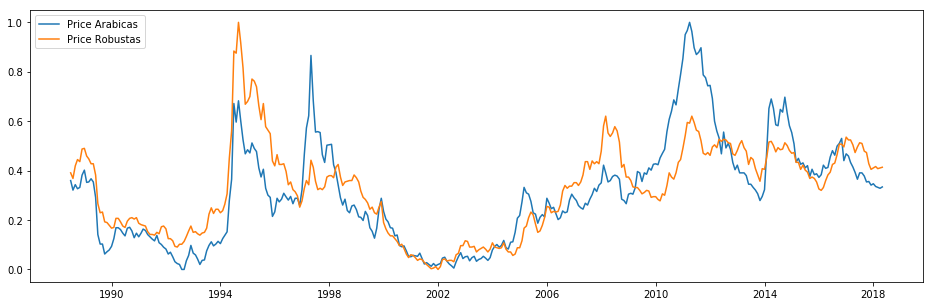

In [14]:
plt.figure(figsize=(16,5))

plt.plot(df_prices_norm['Price Arabicas'])
plt.plot(df_prices_norm['Price Robustas'])
#plt.plot(df_prices_norm['Price Oil avg.'])
plt.legend(['Price Arabicas', 'Price Robustas'], loc='upper left')

plt.show()

Prices of Arabicas and Robustas are highly correlated. Let's check on correlation index.

In [15]:
corrs=df_prices_norm.corr()
print(corrs["Price Robustas"])

Price Arabicas    0.786110
Price Robustas    1.000000
Vol. Oil Total    0.394911
Price Oil avg.    0.382675
Name: Price Robustas, dtype: float64


## Time series analysis of core dataset

Le'ts look closer to coffee prices. As data are provided on time basis, a further time series analysis is requied to detect seasonality, stationarity etc.

### Seasonality and trend

In [16]:
focus = [ 'Price Robustas','Price Arabicas']

Price Robustas


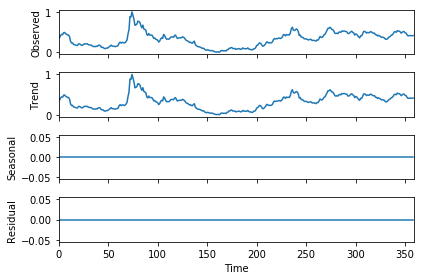

Price Arabicas


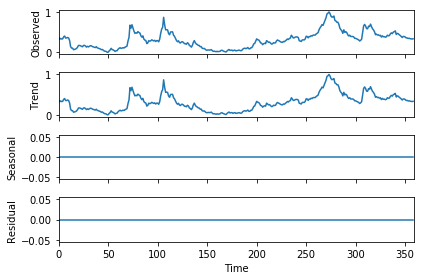

In [17]:
def plot_decomposions(X, f):    
    print(f)
    result1 = seasonal_decompose(X, model='additive', freq=1).plot()
    #result2 = seasonal_decompose(X, model='multiplicative', freq=1).plot()
    plt.show()

for f in focus:
    X = df_prices_norm[ f ].values
    plot_decomposions(X, f)

No seasonality and trend was observed. Trends just copy observations.

### Stationarity

In [18]:
def check_stationarity(X, f):
    print( f )
    result = adfuller(X)
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for k, v in result[4].items():
        print('\t %s: %.3f' % (k, v))
    print()

for f in focus:
    X = df_prices_norm[ f ].values
    check_stationarity(X, f)

Price Robustas
ADF Statistic: -2.586742
p-value: 0.095769
Critical Values:
	 1%: -3.449
	 5%: -2.870
	 10%: -2.571

Price Arabicas
ADF Statistic: -2.772029
p-value: 0.062382
Critical Values:
	 1%: -3.449
	 5%: -2.870
	 10%: -2.571



In all cases p-value is higher than any critical value (0.01 or 0.05), although not that far. In abs view stat. result is very close 0.05 crit. value., still none of time series tested can reject null hypothesis, i.e. is non-stationary and has some small time-dependent structure.

### Autocorrelation

Price Robustas


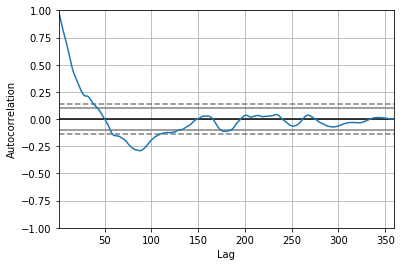

Price Arabicas


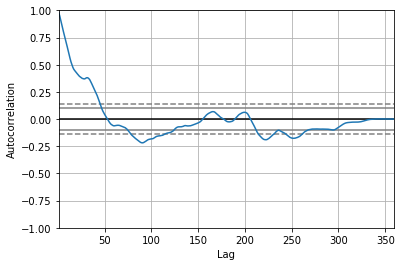

In [19]:
for f in focus:
    print ( f )
    X = df_prices_norm[ f ].values
    autocorrelation_plot( X )
    plt.show()

Both converge to 0 auto-correlation after lag 40.

### ARIMA model

In [20]:
def get_best_params_for_arima ( X ):
    
    results = []
    results_params = []
    
    for p_lag in range(1,20):
        for p_diff_order in range(1,3):
            model = ARIMA( X, order=(p_lag,p_diff_order,0) )
            model_fit = model.fit(disp=0)
            residuals = pd.DataFrame(model_fit.resid)
            residuals_described = residuals.describe()
            
            results.append(
                ( abs(residuals_described.loc['min'].values[0]),
                 residuals_described.loc['max'].values[0],
                 residuals_described.loc['std'].values[0])
            )
            results_params.append( (p_lag, p_diff_order) )
    
    results_df = pd.DataFrame(results, columns=["min","max","std"])
    results_params_df = pd.DataFrame(results_params, columns=["lag","diff_order"])
    results_and_params_df = pd.concat ( [results_df,results_params_df], axis=1  )

    return results_and_params_df.sort_values( ['std', 'max','min'], ascending=[True, True, True] ).iloc[0]

In [21]:
for f in focus:
    print ( f )
    best_params = get_best_params_for_arima( df_prices_norm[ f ] )
    print ( best_params )    


Price Robustas


C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Us

C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Us

min            0.110467
max            0.276597
std            0.033141
lag           19.000000
diff_order     1.000000
Name: 36, dtype: float64
Price Arabicas


C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Us

C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Us

min            0.199361
max            0.275746
std            0.042056
lag           19.000000
diff_order     1.000000
Name: 36, dtype: float64


Price Robustas<br>

min           0.111709
max           0.279121
std           0.033862
lag           9.000000
diff_order    1.000000

min            0.110467
max            0.276597
std            0.033141
lag           19.000000
diff_order     1.000000

        
Price Arabicas<br>

min           0.214732
max           0.277304
std           0.042899
lag           9.000000
diff_order    1.000000

min            0.199361
max            0.275746
std            0.042056
lag           19.000000
diff_order     1.000000

ARIMA model performed best for params: lag value 9 or 19 and diff order 1. 19 is very close to 2 x 9. There is 'month' as basis for time series, and so 9 means 3 quarters. 3 quarters lag seems to have impact.

Let' visualise those results.

Price Robustas



C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:       D.Price Robustas   No. Observations:                  358
Model:                 ARIMA(9, 1, 0)   Log Likelihood                 704.521
Method:                       css-mle   S.D. of innovations              0.034
Date:                Fri, 28 Sep 2018   AIC                          -1387.042
Time:                        01:50:58   BIC                          -1344.356
Sample:                    08-01-1988   HQIC                         -1370.066
                         - 05-01-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.867e-05      0.003      0.007      0.994      -0.005       0.005
ar.L1.D.Price Robustas     0.2391      0.053      4.530      0.000       0.136       0.343
ar.L

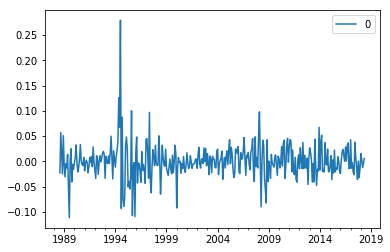

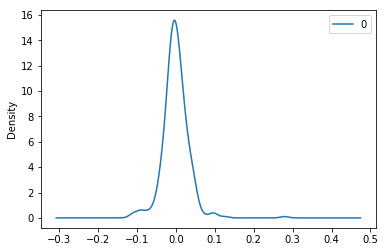

                0
count  358.000000
mean     0.000025
std      0.033862
min     -0.111709
25%     -0.015549
50%     -0.001770
75%      0.015577
max      0.279121
Price Arabicas



C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:       D.Price Arabicas   No. Observations:                  358
Model:                 ARIMA(9, 1, 0)   Log Likelihood                 619.796
Method:                       css-mle   S.D. of innovations              0.043
Date:                Fri, 28 Sep 2018   AIC                          -1217.592
Time:                        01:51:00   BIC                          -1174.907
Sample:                    08-01-1988   HQIC                         -1200.616
                         - 05-01-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -9.229e-05      0.003     -0.032      0.975      -0.006       0.006
ar.L1.D.Price Arabicas     0.1631      0.053      3.091      0.002       0.060       0.267
ar.L

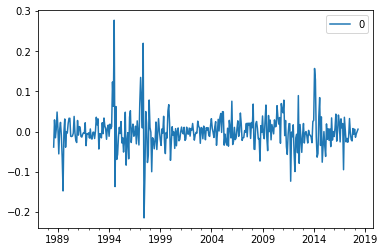

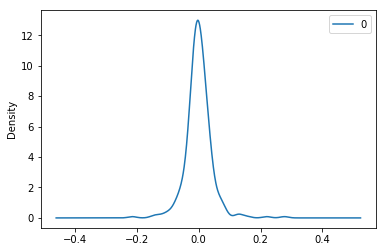

                0
count  358.000000
mean     0.000022
std      0.042899
min     -0.214732
25%     -0.018906
50%     -0.001820
75%      0.019265
max      0.277304


In [22]:
for f in focus:   
    print (f )
    print()
    X = df_prices_norm[ f ] 
    
    model = ARIMA( X, order=(9,1,0) )
    model_fit = model.fit(disp=0)    
    print( model_fit.summary() )

    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()

    residuals.plot(kind='kde')
    plt.show()

    print(residuals.describe())


9 for p parameter (or lags) would generate quite complex equation / model and yet there are extreme residuals >25%.

## Correlations

After analysis of core dataset, let's add additional data to the mix such as Crude Oil, Production and consumption (~ Import to other countries).

### Crude Oil

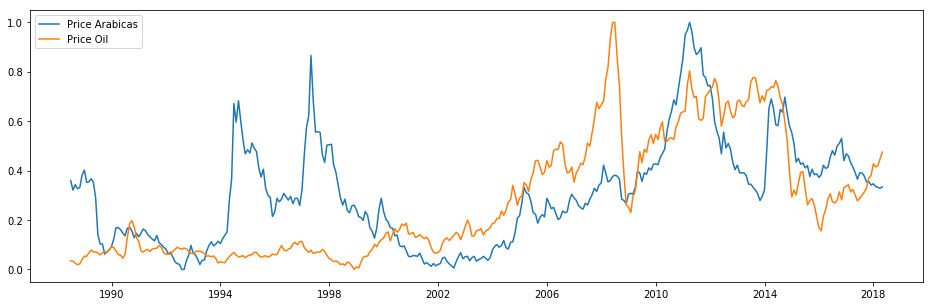

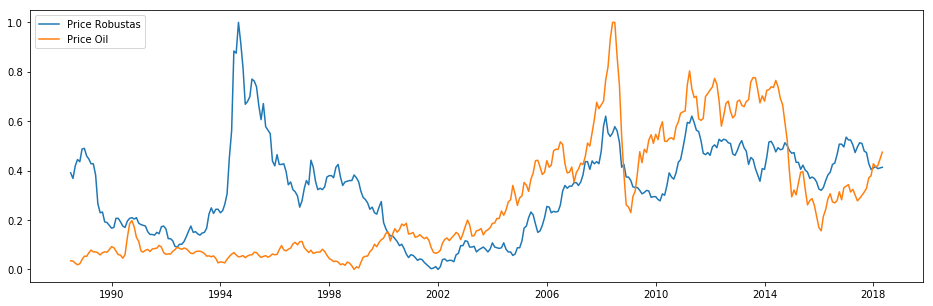

In [23]:
plt.figure(figsize=(16,5))

plt.plot(df_prices_norm['Price Arabicas'])
plt.plot(df_prices_norm['Price Oil avg.'])
plt.legend(['Price Arabicas', 'Price Oil'], loc='upper left')

plt.show()


plt.figure(figsize=(16,5))

plt.plot(df_prices_norm['Price Robustas'])
plt.plot(df_prices_norm['Price Oil avg.'])
plt.legend(['Price Robustas', 'Price Oil'], loc='upper left')

plt.show()

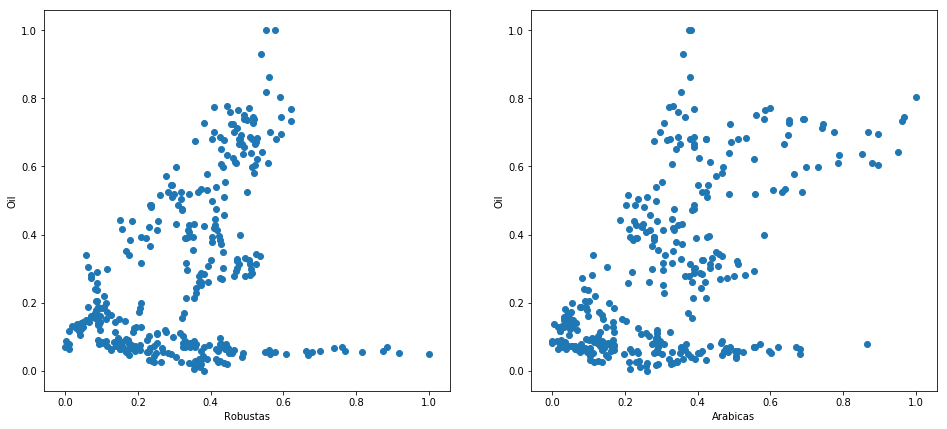

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

axs[0].scatter(df_prices_norm['Price Robustas'], df_prices_norm['Price Oil avg.'])
axs[0].set_xlabel('Robustas')
axs[0].set_ylabel('Oil')

axs[1].scatter(df_prices_norm['Price Arabicas'], df_prices_norm['Price Oil avg.'])
axs[1].set_xlabel('Arabicas')
axs[1].set_ylabel('Oil')

plt.show()

Oil and coffee prices correlate only from certian data point - as of 2002. This is clearly visible also on scatter plots, where "V" shape appears, with one leg almost horizontal (coffe changing, while oil remains unchanged).

### Production

In [25]:
raw_production_data = pd.read_csv(file_paths["production_data"], encoding = "ANSI")
raw_production_data.drop(0,axis=0,inplace=True)

Clean up and transform raw data from dataset

In [26]:
'''
Data for years are provided as two years pair, e.g. 1993/1994 ... this function extracts two years as touple of numbers

Input raw string
Return touple of two numbers
'''
def get_production_years(inpt_str):
    pos_of_slash = inpt_str.find('/')    
    if pos_of_slash==4:
        year1=inpt_str[0:4]
        year2=int(year1)+1
    return(year1,year2)

In [27]:
'''
Get production by year and country with year as index

Source data about production were provided as annual for seaon spanning across two year, 
and so this data point needs to be adjusted before it is merged with other dataframes. 

Input dataframe
Returns dataframe
'''

def transform_production_data_from_ico(raw_df):
    raw_df = pd.melt(raw_df, id_vars=["Country"], var_name=["Country name"], value_name="Production")
    
    raw_df.rename(columns = {'Country':'Year'}, inplace = True)
    
    raw_df['Production']=raw_df['Production'].astype('float64')
    
    raw_df2 = raw_df.copy()    
    
    raw_df['Year']=raw_df['Year'].apply(lambda x: get_production_years(x)[0])
    raw_df['Production']=raw_df['Production'].apply(lambda x: x/2)
    
    raw_df2['Year']=raw_df2['Year'].apply(lambda x: get_production_years(x)[1])
    raw_df2['Production']=raw_df2['Production'].apply(lambda x: x/2)
    
    raw_df_final = pd.concat([raw_df, raw_df2])
    
    raw_df_final['Year']=raw_df_final['Year'].astype('int64')
    
    df = raw_df_final.groupby(['Year','Country name'],as_index=False).sum()
    df.set_index('Year', inplace=True)
    
    return df

In [28]:
df_production = transform_production_data_from_ico(raw_production_data)
#print(df_production.head())

Drop production for 1st and last year as they contain only half-year volumes.

In [29]:
df_production = df_production.drop(df_production.index[[0,28]])

Show production by years.

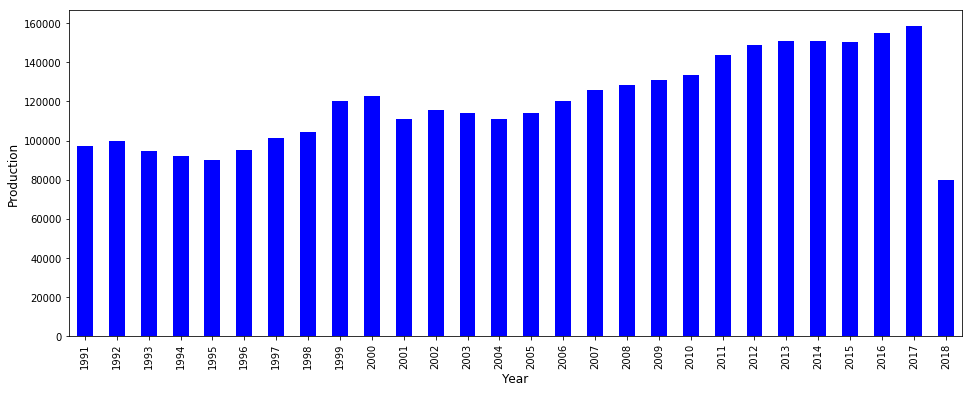

In [30]:
plt.figure(figsize=(16,6))

ax = df_production.groupby(df_production.index).sum()['Production'].plot(kind='bar',color='b')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Production", fontsize=12)
plt.show()

### Demand ~ import

Load and clean source data.

In [31]:
raw_import_data = pd.read_csv(file_paths["import_data"], encoding = "ANSI")

In [32]:
#print(raw_import_data.head())

In [33]:
'''
Fix number provided as text with formatting into float data type

Input whole dataframe
Output whole dataframe
'''

def transform_import_data_from_ico(raw_df):
    raw_df = pd.melt(raw_df, id_vars=["Country"], var_name=["Year"], value_name="Import")
    
    raw_df['Import'] = raw_df['Import'].str.replace(',','')
    raw_df['Import'] = raw_df['Import'].str.replace('-','')
    raw_df['Import'] = raw_df['Import'].str.replace(' ','0')
    #raw_df.replace(r'\s+',np.nan,regex=True).replace('',np.nan)
    #raw_df['Import'] = raw_df['Import'].apply(lambda x: if len(x)==0: x='0.0')
    #print(raw_df['Import'].head(100))
    raw_df['Import']=raw_df['Import'].astype('float64')
    
    raw_df['Year']=raw_df['Year'].astype('int64')

    raw_df.set_index('Year', inplace=True)
    
    return raw_df

In [34]:
df_import = transform_import_data_from_ico(raw_import_data)
#print(df_import.head())

Plot both import and production on same chart to see if there were any gaps.

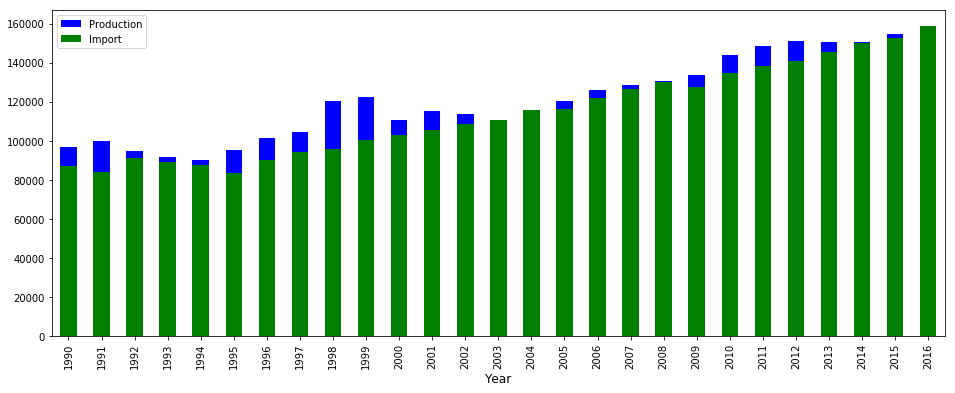

In [35]:
plt.figure(figsize=(16,6))

ax = df_production.groupby(df_production.index).sum()['Production'].plot(kind='bar', color='b')
ax = df_import.groupby(df_import.index).sum()['Import'].plot(kind='bar', color='g')
ax.set_xlabel("Year", fontsize=12)

plt.legend(['Production', 'Import'], loc='upper left')

plt.show()

There were years with over production, could this have impact on price?

Let's try to merge all data frames into one master dataframe and investigate.

In [36]:
df_import.drop(['Country'], axis=1, inplace=True)
df_import = df_import.groupby( df_import.index ).agg( { 'Import': "sum" } )

df_production.drop(['Country name'], axis=1, inplace=True)
df_production = df_production.groupby( df_production.index ).agg( { 'Production': "sum" } )

In [37]:
df_import_norm = ( df_import - df_import.min() ) / ( df_import.max() - df_import.min() )
df_production_norm = ( df_production - df_production.min() ) / ( df_production.max() - df_production.min() )

In [38]:
#df_production_norm

In [39]:
# further reduce granularity of prices dataframe from Year-month to Year only

df_prices_norm["Year"] = df_prices_norm.index.year

df_prices_norm = df_prices_norm.groupby( ['Year'], as_index=True ).agg( { 'Price Arabicas': 'mean' , 'Price Robustas':'mean', 'Price Oil avg.':'mean' } )

In [40]:
main_df = df_import_norm.join(df_production_norm)
main_df = main_df.join(df_prices_norm)
main_df.dropna(inplace=True)

Create new feature showing delta between Production and import

In [41]:
main_df["Prod. Import delta"] = main_df["Production"]-main_df["Import"]

In [42]:
#main_df.plot( figsize=(16,8) )

Display all data in one chart

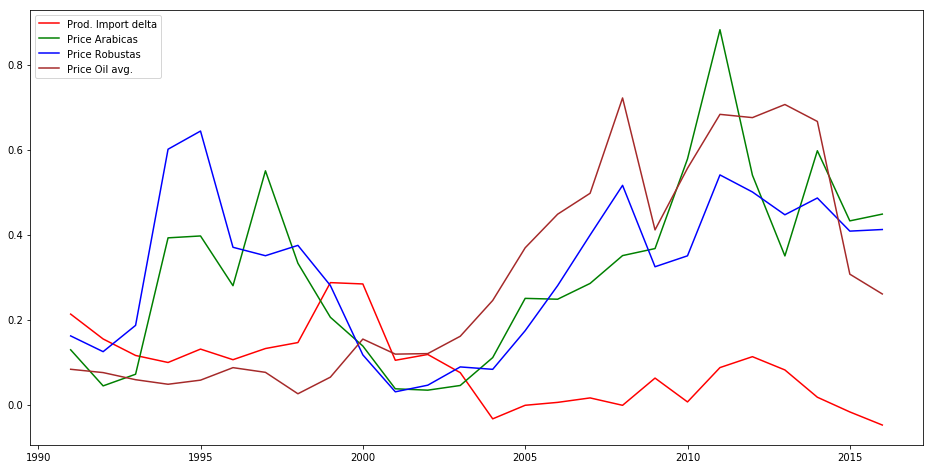

In [43]:
plt.figure( figsize=(16,8) )

plt.gca().set_prop_cycle('color',['red', 'green','blue','brown'])

plt.plot(main_df['Prod. Import delta'])
plt.plot(main_df['Price Arabicas'])
plt.plot(main_df['Price Robustas'])
plt.plot(main_df['Price Oil avg.'])

plt.legend(['Prod. Import delta', 'Price Arabicas','Price Robustas','Price Oil avg.'], loc='upper left')

plt.show()

Check on correlations after 2001 (for which Coffee-Crude Oil relationship is trong and explained).

In [44]:
main_df[ main_df.index>2001 ].corr()

,Import,Production,Price Arabicas,Price Robustas,Price Oil avg.,Prod. Import delta
Import,1.000000,0.966996,0.704475,0.795856,0.460018,-0.239704
Production,0.966996,1.000000,0.735287,0.815991,0.515148,0.015569
Price Arabicas,0.704475,0.735287,1.000000,0.828780,0.696696,0.037131
Price Robustas,0.795856,0.815991,0.828780,1.000000,0.838640,-0.013964
Price Oil avg.,0.460018,0.515148,0.696696,0.838640,1.000000,0.157646
Prod. Import delta,-0.239704,0.015569,0.037131,-0.013964,0.157646,1.000000


Check on corr. after 2005 as Prod.-Import delta seems to be related to prices.

In [45]:
main_df[ main_df.index>2005 ].corr()

,Import,Production,Price Arabicas,Price Robustas,Price Oil avg.,Prod. Import delta
Import,1.000000,0.949990,0.338864,0.388261,-0.213339,-0.212842
Production,0.949990,1.000000,0.455167,0.507835,-0.016398,0.102926
Price Arabicas,0.338864,0.455167,1.000000,0.579822,0.336924,0.344798
Price Robustas,0.388261,0.507835,0.579822,1.000000,0.639305,0.352247
Price Oil avg.,-0.213339,-0.016398,0.336924,0.639305,1.000000,0.628228
Prod. Import delta,-0.212842,0.102926,0.344798,0.352247,0.628228,1.000000


## Conclusions

Let's get back to questions asked at the beginning:
> 1. Prices for Arabicas and Robustas are very close to each other, Pearson's index of correlation shows almost 0.8.
> 2. Time series discovery proved that there is no seasonality / trend, nor any major component influencing change to decent level. 
> 3. Coffee do correlate positively with Crude Oil price, price of Robustas is more sensitive to changes of Crude Oil prices.
> 4. Production and Import delta does not influence prices that much, although after 2005 overall correlation with Crude Oil is almost two thirds (positive) that raises questions for further analysis.

In general relationship between datapoints after 2001 behave differently, this can indicate either shift in whole environment which could be explained by additional variable (not in scope of this analysis), or issue with source data.

## Data sources

Arabica Coffee - Monthly Price - US Dollars per Kilogram<br>
https://www.indexmundi.com/commodities/?commodity=other-mild-arabicas-coffee&months=360

Robusta Coffee - Monthly Price - US Dollars per Kilogram<br>
https://www.indexmundi.com/commodities/?commodity=robusta-coffee&months=360

Crude Oil - WTI Futures <br>
https://www.investing.com/commodities/crude-oil

Production and Import <br>
International Coffee Organization at http://www.ico.org/new_historical.asp?section=Statistics